In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import PIL.Image
from pathlib import Path
import torchvision

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import json
import time
import timm

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
nfolds = 4
fname = 'resnet50'#'resnext50'#'RSNT18'
IMAGE_DIR = '/kaggle/input/panda-16x128x128-tiles-data/train'
LABELS = '/kaggle/input/prostate-cancer-grade-assessment/train.csv'
SEED = 2024

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# loss_name = "mse"
# TRAIN_DATASET_FRAC = 1
# num_epochs = 50
# EARLY_STOPPING = True
# MIN_EPOCH = 20
# PATIENCE = 10

loss_name = "mse"
TRAIN_DATASET_FRAC = 1
num_epochs = 20
EARLY_STOPPING = True
MIN_EPOCH = 10
PATIENCE = 8

## Seed everything

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## Dataset class

In [ ]:
class ProstateTilesDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, n_tiles=(3, 4), transform=None):
        self.df = df
        self.image_dir = image_dir
        self.n_tiles = n_tiles
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id = row.image_id
        label = row.isup_grade
        tile_rows, tile_cols = self.n_tiles
        imgs = []
        for i in range(tile_rows):
            for j in range(tile_cols):
                img_path = Path(self.image_dir, f'{img_id}_{i * tile_cols + j}.png')
                img = PIL.Image.open(img_path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                imgs.append(img)
        imgs = torch.stack(imgs) # (12, 3, 128, 128)
        return imgs, label

## Model

In [ ]:
class CustomPool(nn.Module):
    def __init__(self, N=12):
        super(CustomPool, self).__init__()
        self.avg_pool = nn.AvgPool1d(kernel_size=N)
        self.max_pool = nn.MaxPool1d(kernel_size=N)

    def forward(self, x):
        # x = (BS, 12, 2048)
        x = x.transpose(1, 2)  # (BS, 512, 12)
        avg_pooled = self.avg_pool(x).squeeze(-1)  # (BS, 512)
        max_pooled = self.max_pool(x).squeeze(-1)  # (BS, 512)
        concatenated_features = torch.cat((avg_pooled, max_pooled), dim=1)  # (BS, 512*2)
        return concatenated_features

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes=1): # change back to 6
        super().__init__()
        #self.enc = timm.create_model('resnet18', pretrained=True, num_classes=0)
        #self.enc = timm.create_model('resnext50_32x4d.fb_ssl_yfcc100m_ft_in1k', pretrained=True, num_classes=0)
        self.enc = timm.create_model('resnet50.a1_in1k', pretrained=True, num_classes=0)


        nc = self.enc.feature_info[-1]['num_chs']
        self.pool = CustomPool()
        self.head = nn.Sequential(
            nn.Linear(nc*2,512), # (BS, 12, 512)
            nn.BatchNorm1d(512),
            nn.Mish(),
            nn.Dropout(0.25),

            nn.Linear(512,256),
            nn.BatchNorm1d(256),
            nn.Mish(),
            nn.Dropout(0.25),

            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.Mish(),
            nn.Dropout(0.25),

            nn.Linear(128,num_classes)
        )

    def forward(self, x):
        # x = (BS, 12, 3, 128, 128)
        n = x.shape[1]
        x = x.view(-1, x.shape[2], x.shape[3], x.shape[4]) # (BS*12, 3, 128, 128)
        x = self.enc(x) # (BS*12, nc)
        x = x.view(-1,n,x.shape[1]) # (BS, 12, nc)
        x = self.pool(x) # (BS, 512*2)
        x = self.head(x)
        return x

## Training utility functions

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    start_time = time.time()
    with tqdm(
        dataloader,
        desc=(f"Epoch {epoch} - Train"),
        unit=" slide",
        unit_scale=BATCH_SIZE,
        leave=False,
    ) as t:
        for inputs, labels in t:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float()
            outputs = model(inputs)
            if loss_name == "mse":
                loss = criterion(outputs.squeeze(-1), labels)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    end_time = time.time()
    return average_loss

In [ ]:
def go_from_mse_logit_to_prediction(logit):
    if logit < 0.5:
        return 0
    elif logit < 1.5:
        return 1
    elif logit < 2.5:
        return 2
    elif logit < 3.5:
        return 3
    elif logit < 4.5:
        return 4
    else:
        return 5

In [ ]:
def tune(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    start_time = time.time()
    with tqdm(
        dataloader,
        desc=(f"Epoch {epoch} - Tune"),
        unit=" slide",
        unit_scale=BATCH_SIZE,
        leave=False,
    ) as t:
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float()
                outputs = model(inputs)
                if loss_name == "mse":
                    loss = criterion(outputs.squeeze(-1), labels)
                else:
                    loss = criterion(outputs, labels)
                total_loss += loss.item()
                if loss_name == "mse":
                    preds = [go_from_mse_logit_to_prediction(o) for o in outputs]
                else:
                    preds = outputs.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

    average_loss = total_loss / len(dataloader)
    end_time = time.time()
    elapsed_time = end_time - start_time
    kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return average_loss, kappa, all_preds, all_labels

In [ ]:
def log_metrics(epoch, fold, train_loss, tune_loss, kappa):
    logs = {'epoch': epoch, 'fold': fold, 'train_loss': train_loss, 'tune_loss': tune_loss, 'kappa': kappa}
    logs_folder = Path("/kaggle/working/logs")
    logs_folder.mkdir(exist_ok=True)
    log_file = Path(logs_folder, f'log_{fname}_{fold}.json')
    if log_file.is_file():
        with open(log_file, 'r') as file:
            data = json.load(file)
    else:
        data = []
    data.append(logs)
    with open(log_file, 'w') as file:
        json.dump(data, file)

In [ ]:
def save_best_model(model, best_val, current_val, fold, epoch, min_max="min"):
    improve_flag = False
    if min_max == "max":
        best_val = -1 * best_val
        current_val = -1 * current_val
    if current_val < best_val:
        improve_flag = True
        best_val = current_val
        torch.save(model.state_dict(), f'{fname}_{fold}.pth')
        print(f"Saved better model for fold {fold} at epoch {epoch}")
    if min_max == "max":
        best_val = -1 * best_val
    return best_val, improve_flag

## Model training

In [ ]:
df = pd.read_csv(LABELS)
df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [ ]:
# grab slide ids in /kaggle/input/panda-16x128x128-tiles-data
slide_ids = list(set([fp.stem.split("_")[0] for fp in Path(IMAGE_DIR).glob("*.png")]))
len(slide_ids)

10516

In [ ]:
# restrict previous dataframe to those ids
df_restricted = df[df.image_id.isin(slide_ids)].reset_index(drop=True)
len(df) - len(df_restricted)

100

In [ ]:
skf = StratifiedKFold(n_splits=nfolds, random_state=SEED, shuffle=True)
X = df_restricted.image_id.values
y = df_restricted.isup_grade.values
train_dfs, tune_dfs = [], []
for i, (train_index, tune_index) in enumerate(skf.split(X, y)):
    train_df, tune_df = df_restricted.loc[train_index], df_restricted.loc[tune_index]
    if TRAIN_DATASET_FRAC < 1.0:
        train_df = train_df.sample(frac=TRAIN_DATASET_FRAC, random_state=SEED)
    train_df = train_df.reset_index(drop=True)
    tune_df = tune_df.reset_index(drop=True)
    train_dfs.append(train_df)
    tune_dfs.append(tune_df)
    print(f"fold {i+1}/{nfolds}: train={len(train_df)}, tune={len(tune_df)}")

fold 1/4: train=7887, tune=2629
fold 2/4: train=7887, tune=2629
fold 3/4: train=7887, tune=2629
fold 4/4: train=7887, tune=2629


In [ ]:
mean = torch.tensor([1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304])
std = torch.tensor([0.36357649, 0.49984502, 0.40477625])

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),

#     # more augmentations (added):
#     transforms.RandomResizedCrop(size=int(0.85*IMAGE_SIZE)),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=[-0.03,0.04]),


    transforms.ToTensor(),
    transforms.Normalize(mean, std)

])

In [ ]:
def show_image(img_tensor, title):
    img = img_tensor.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
all_folds_preds = []
all_folds_labels = []
for fold in range(nfolds):

    train_dataset = ProstateTilesDataset(train_dfs[fold], IMAGE_DIR, transform=transform)
    tune_dataset = ProstateTilesDataset(tune_dfs[fold], IMAGE_DIR, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    tune_loader = torch.utils.data.DataLoader(tune_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    if loss_name == "mse":
        num_classes =  1
        criterion = nn.MSELoss()
    else:
        num_classes = 6
        criterion = nn.CrossEntropyLoss()

    model = Model(num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_kappa = -np.inf
    best_loss = np.inf
    best_fold_dict = {
            "epochs": [None] * num_epochs,
            "kappa": [None] * num_epochs,
            "preds": [None] * num_epochs,
            "labels": [None] * num_epochs,
            "loss": [float('inf')] * num_epochs
        }



    early_stopping_count = 0

    with tqdm(
        range(num_epochs),
        desc=f"Fold {fold+1}/{nfolds}",
        unit=" epoch",
        leave=True,
    ) as t:
        for epoch in t:
            train_loss = train(model, train_loader, criterion, optimizer, device)
            tqdm.write(f"Epoch {epoch} - train_loss: {train_loss:.4f}")
            valid_loss, kappa, fold_preds, fold_labels = tune(model, tune_loader, criterion, device)
            tqdm.write(f"Epoch {epoch} - tune loss: {valid_loss:.4f}")
            tqdm.write(f"Epoch {epoch} - tune kappa: {kappa:.4f}")
            log_metrics(epoch, fold, train_loss, valid_loss, kappa)

            best_fold_dict["epochs"][epoch] = (epoch + 1)
            best_fold_dict["kappa"][epoch] = kappa
            best_fold_dict["preds"][epoch] = fold_preds
            best_fold_dict["labels"][epoch] = fold_labels
            best_fold_dict["loss"][epoch] = valid_loss


            # best_kappa, improve_flag = save_best_model(model, best_kappa, kappa, fold, epoch, min_max="max")
            best_loss, improve_flag = save_best_model(model, best_loss, valid_loss, fold, epoch,  min_max="min")
            if not improve_flag:
                early_stopping_count += 1
            if EARLY_STOPPING and early_stopping_count > PATIENCE and epoch >= MIN_EPOCH:
                print(f"Epoch {epoch} - Stopping early as model didn't improve over the last {PATIENCE} epochs")
                break


    # get best epoch based on lowest loss
    min_value_index = best_fold_dict['loss'].index(min(best_fold_dict['loss']))
    best_epoch = best_fold_dict['epochs'][min_value_index]
    loss_best = best_fold_dict['loss'][min_value_index]
    print(f'Best performing epoch of fold {fold +1} is {best_epoch} with a loss of {loss_best}')

    all_folds_preds.extend(best_fold_dict["preds"][min_value_index])
    all_folds_labels.extend(best_fold_dict["labels"][min_value_index])


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Fold 1/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 2.2505


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.6006
Epoch 0 - tune kappa: 0.5877
Saved better model for fold 0 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.5180


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.8034
Epoch 1 - tune kappa: 0.5491


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.3275


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.4779
Epoch 2 - tune kappa: 0.6263
Saved better model for fold 0 at epoch 2


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.2029


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.3797
Epoch 3 - tune kappa: 0.6884
Saved better model for fold 0 at epoch 3


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.0467


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.3934
Epoch 4 - tune kappa: 0.7127


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.9490


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.3846
Epoch 5 - tune kappa: 0.7139


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.8199


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.4527
Epoch 6 - tune kappa: 0.6545


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.7319


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.5803
Epoch 7 - tune kappa: 0.6830


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.6646


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.6599
Epoch 8 - tune kappa: 0.6862


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.5898


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.1977
Epoch 9 - tune kappa: 0.7541
Saved better model for fold 0 at epoch 9


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.5445


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.2617
Epoch 10 - tune kappa: 0.7214


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.5043


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.3231
Epoch 11 - tune kappa: 0.7383


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 0.3972


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.3016
Epoch 12 - tune kappa: 0.7316
Epoch 12 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 1 is 10 with a loss of 1.197731200470982


Fold 2/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 2.1895


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.4430
Epoch 0 - tune kappa: 0.6901
Saved better model for fold 1 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.5143


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.3498
Epoch 1 - tune kappa: 0.6721
Saved better model for fold 1 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.2934


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.2931
Epoch 2 - tune kappa: 0.7394
Saved better model for fold 1 at epoch 2


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.1622


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.4074
Epoch 3 - tune kappa: 0.7100


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.0446


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.4782
Epoch 4 - tune kappa: 0.7341


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.9346


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.5899
Epoch 5 - tune kappa: 0.6862


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.7681


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.2285
Epoch 6 - tune kappa: 0.7417
Saved better model for fold 1 at epoch 6


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.6777


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.2898
Epoch 7 - tune kappa: 0.7271


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.6449


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.2168
Epoch 8 - tune kappa: 0.7104
Saved better model for fold 1 at epoch 8


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.5582


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.1953
Epoch 9 - tune kappa: 0.7233
Saved better model for fold 1 at epoch 9


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.4893


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.2800
Epoch 10 - tune kappa: 0.6898


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.4418


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.1490
Epoch 11 - tune kappa: 0.7483
Saved better model for fold 1 at epoch 11


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 0.4265


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.1432
Epoch 12 - tune kappa: 0.7731
Saved better model for fold 1 at epoch 12


Epoch 13 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 0.4391


Epoch 13 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.3541
Epoch 13 - tune kappa: 0.7312


Epoch 14 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 14 - train_loss: 0.4263


Epoch 14 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 14 - tune loss: 1.5629
Epoch 14 - tune kappa: 0.7059


Epoch 15 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 15 - train_loss: 0.3743


Epoch 15 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 15 - tune loss: 1.0666
Epoch 15 - tune kappa: 0.7691
Saved better model for fold 1 at epoch 15


Epoch 16 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 16 - train_loss: 0.3491


Epoch 16 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 16 - tune loss: 1.1704
Epoch 16 - tune kappa: 0.7517


Epoch 17 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 17 - train_loss: 0.3140


Epoch 17 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 17 - tune loss: 1.1607
Epoch 17 - tune kappa: 0.7427
Epoch 17 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 2 is 16 with a loss of 1.066632350884288


Fold 3/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 2.0065


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.6754
Epoch 0 - tune kappa: 0.6118
Saved better model for fold 2 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.4840


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.5227
Epoch 1 - tune kappa: 0.6062
Saved better model for fold 2 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.3160


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 2.1025
Epoch 2 - tune kappa: 0.5918


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.1323


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.2488
Epoch 3 - tune kappa: 0.7170
Saved better model for fold 2 at epoch 3


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.0069


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.5178
Epoch 4 - tune kappa: 0.6863


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.9183


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.6315
Epoch 5 - tune kappa: 0.6565


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.8108


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.3448
Epoch 6 - tune kappa: 0.7282


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.6941


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.1994
Epoch 7 - tune kappa: 0.7248
Saved better model for fold 2 at epoch 7


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.6499


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.2701
Epoch 8 - tune kappa: 0.7043


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.5771


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.6383
Epoch 9 - tune kappa: 0.6833


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.5357


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.9344
Epoch 10 - tune kappa: 0.5815


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.5015


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.2118
Epoch 11 - tune kappa: 0.7395


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 0.4500


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.5330
Epoch 12 - tune kappa: 0.6965
Epoch 12 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 3 is 8 with a loss of 1.199399350637413


Fold 4/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 2.2944


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.8156
Epoch 0 - tune kappa: 0.4942
Saved better model for fold 3 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.4583


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.3737
Epoch 1 - tune kappa: 0.7112
Saved better model for fold 3 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.3143


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.4214
Epoch 2 - tune kappa: 0.6730


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.2042


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.3186
Epoch 3 - tune kappa: 0.7238
Saved better model for fold 3 at epoch 3


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.0742


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.7838
Epoch 4 - tune kappa: 0.6542


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.9419


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.7021
Epoch 5 - tune kappa: 0.6646


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.8640


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.2952
Epoch 6 - tune kappa: 0.7370
Saved better model for fold 3 at epoch 6


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.7429


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.1623
Epoch 7 - tune kappa: 0.7569
Saved better model for fold 3 at epoch 7


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.6056


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.1773
Epoch 8 - tune kappa: 0.7488


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.5847


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.2861
Epoch 9 - tune kappa: 0.7392


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.5084


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.1831
Epoch 10 - tune kappa: 0.7469


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.4528


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.2041
Epoch 11 - tune kappa: 0.7689


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 0.4183


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.1791
Epoch 12 - tune kappa: 0.7767


Epoch 13 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 0.4091


Epoch 13 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.0885
Epoch 13 - tune kappa: 0.7799
Saved better model for fold 3 at epoch 13


Epoch 14 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 14 - train_loss: 0.4202


Epoch 14 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 14 - tune loss: 1.3496
Epoch 14 - tune kappa: 0.7098
Epoch 14 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 4 is 14 with a loss of 1.0884902073317264


Overall CV Score: 0.7579


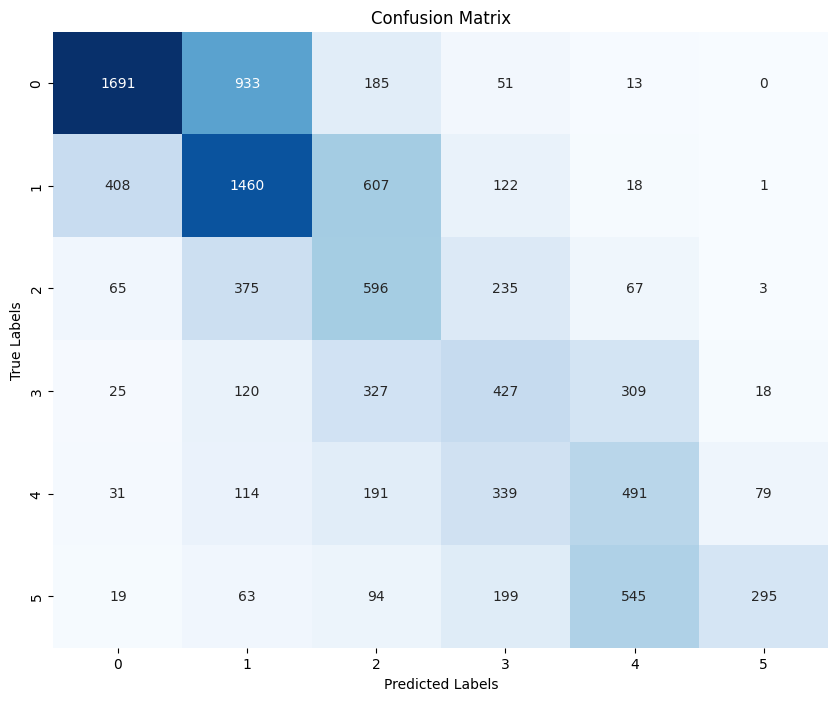

In [ ]:
preds_array = np.array(all_folds_preds)
labels_array = np.array(all_folds_labels)

kappa_score = cohen_kappa_score(labels_array, preds_array, weights='quadratic')
print(f"Overall CV Score: {kappa_score:.4f}")

cm = confusion_matrix(labels_array, preds_array)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### Plot loss curves

{'epoch': 0, 'fold': 0, 'train_loss': 2.2505115984905104, 'tune_loss': 1.6005662521684025, 'kappa': 0.5876981321598393}
{'epoch': 1, 'fold': 0, 'train_loss': 1.5180208000094302, 'tune_loss': 1.8034399273883865, 'kappa': 0.5490898401833413}
{'epoch': 2, 'fold': 0, 'train_loss': 1.3275093283006536, 'tune_loss': 1.4779277228447327, 'kappa': 0.6262736126630655}
{'epoch': 3, 'fold': 0, 'train_loss': 1.2028889255485071, 'tune_loss': 1.3796622171459427, 'kappa': 0.6883610122949108}
{'epoch': 4, 'fold': 0, 'train_loss': 1.046652855540094, 'tune_loss': 1.3934277899294014, 'kappa': 0.7127371348083347}
{'epoch': 5, 'fold': 0, 'train_loss': 0.9489520680807862, 'tune_loss': 1.3846239023898022, 'kappa': 0.7139046684229167}
{'epoch': 6, 'fold': 0, 'train_loss': 0.8198793309661541, 'tune_loss': 1.4526617419288819, 'kappa': 0.6544563520098627}
{'epoch': 7, 'fold': 0, 'train_loss': 0.7318993142017951, 'tune_loss': 1.5803034840578056, 'kappa': 0.6830202008583508}
{'epoch': 8, 'fold': 0, 'train_loss': 0.6

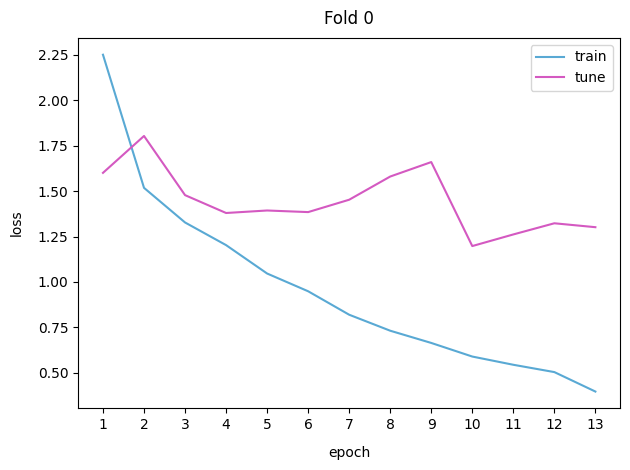

{'epoch': 0, 'fold': 1, 'train_loss': 2.189509550328197, 'tune_loss': 1.4429546450994102, 'kappa': 0.6901100868399956}
{'epoch': 1, 'fold': 1, 'train_loss': 1.5143118865094205, 'tune_loss': 1.349763515124838, 'kappa': 0.6720540078311354}
{'epoch': 2, 'fold': 1, 'train_loss': 1.2934461911680244, 'tune_loss': 1.29308777903936, 'kappa': 0.7394424286591854}
{'epoch': 3, 'fold': 1, 'train_loss': 1.1621956803538056, 'tune_loss': 1.4073698441666294, 'kappa': 0.7100229601460062}
{'epoch': 4, 'fold': 1, 'train_loss': 1.0445774074508112, 'tune_loss': 1.4782055436846722, 'kappa': 0.7341256017106839}
{'epoch': 5, 'fold': 1, 'train_loss': 0.9345626192778228, 'tune_loss': 1.5898678309946175, 'kappa': 0.6861884298356724}
{'epoch': 6, 'fold': 1, 'train_loss': 0.7681158001606281, 'tune_loss': 1.2285448452794407, 'kappa': 0.741687902790584}
{'epoch': 7, 'fold': 1, 'train_loss': 0.6777249952318215, 'tune_loss': 1.289781170437135, 'kappa': 0.72712131016138}
{'epoch': 8, 'fold': 1, 'train_loss': 0.64492319

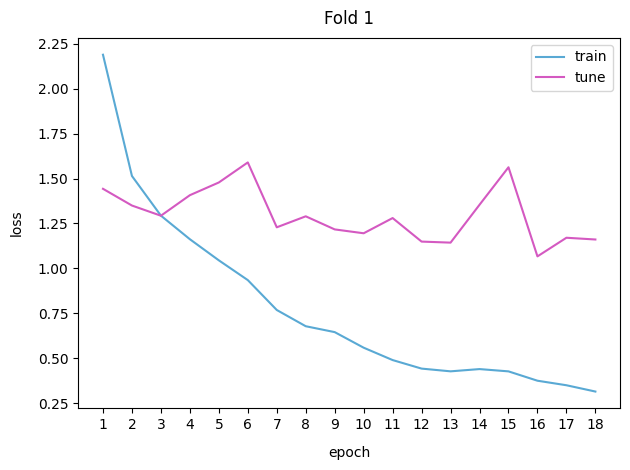

{'epoch': 0, 'fold': 2, 'train_loss': 2.0064722931819405, 'tune_loss': 1.6754334195550666, 'kappa': 0.611823054837457}
{'epoch': 1, 'fold': 2, 'train_loss': 1.4839645836517397, 'tune_loss': 1.5227428136101688, 'kappa': 0.6062099411849364}
{'epoch': 2, 'fold': 2, 'train_loss': 1.3160128121675267, 'tune_loss': 2.102540138256119, 'kappa': 0.5917889772479027}
{'epoch': 3, 'fold': 2, 'train_loss': 1.1323257655749919, 'tune_loss': 1.2487996392939464, 'kappa': 0.7169637509302234}
{'epoch': 4, 'fold': 2, 'train_loss': 1.0069034316761774, 'tune_loss': 1.5178031792123634, 'kappa': 0.686310860261315}
{'epoch': 5, 'fold': 2, 'train_loss': 0.9183067292095679, 'tune_loss': 1.6315138426171727, 'kappa': 0.6565057441618098}
{'epoch': 6, 'fold': 2, 'train_loss': 0.8107862989550177, 'tune_loss': 1.3447624383920647, 'kappa': 0.7281880532944609}
{'epoch': 7, 'fold': 2, 'train_loss': 0.6941249299387218, 'tune_loss': 1.199399350637413, 'kappa': 0.7247524708273148}
{'epoch': 8, 'fold': 2, 'train_loss': 0.6498

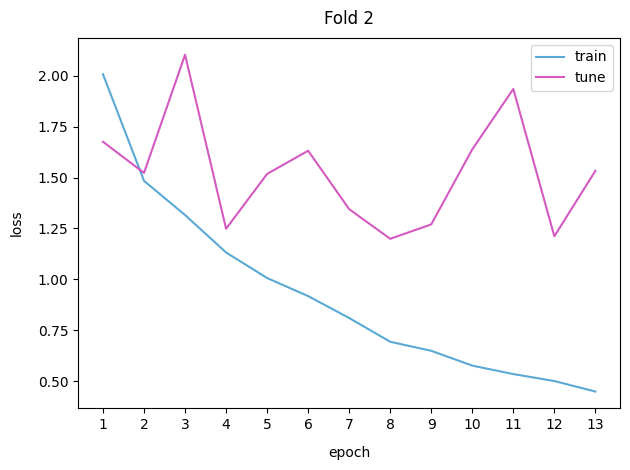

{'epoch': 0, 'fold': 3, 'train_loss': 2.29441660980464, 'tune_loss': 1.815572374556438, 'kappa': 0.49421500609087654}
{'epoch': 1, 'fold': 3, 'train_loss': 1.4583102540689925, 'tune_loss': 1.3736648329769272, 'kappa': 0.7112423934078596}
{'epoch': 2, 'fold': 3, 'train_loss': 1.3142638325932539, 'tune_loss': 1.421364117099578, 'kappa': 0.6730308651187913}
{'epoch': 3, 'fold': 3, 'train_loss': 1.2041923036942115, 'tune_loss': 1.3185707905206336, 'kappa': 0.7238082947165452}
{'epoch': 4, 'fold': 3, 'train_loss': 1.0742074435780407, 'tune_loss': 1.7837647127817913, 'kappa': 0.6542009194914189}
{'epoch': 5, 'fold': 3, 'train_loss': 0.9419409983795182, 'tune_loss': 1.7020944360508976, 'kappa': 0.6646489426226128}
{'epoch': 6, 'fold': 3, 'train_loss': 0.8640034794807434, 'tune_loss': 1.2951857993401676, 'kappa': 0.7370032883450104}
{'epoch': 7, 'fold': 3, 'train_loss': 0.7428856834105635, 'tune_loss': 1.1622967048581825, 'kappa': 0.7568701181454262}
{'epoch': 8, 'fold': 3, 'train_loss': 0.605

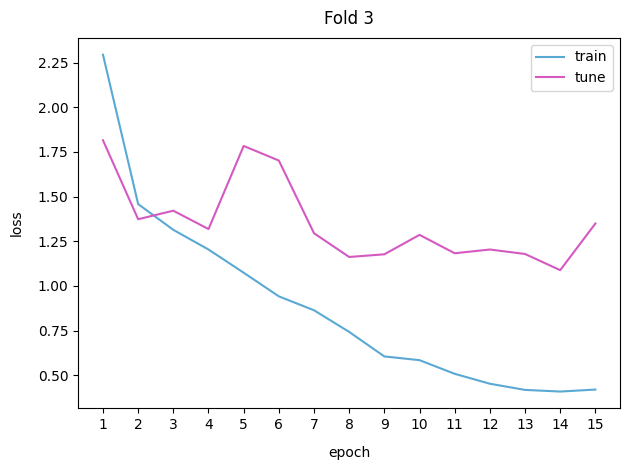

In [ ]:
import matplotlib.pyplot as plt

for fold in range(nfolds):
    with open(f'/kaggle/working/logs/log_{fname}_{fold}.json') as f:
        d = json.load(f)
        epoch = []
        train_loss = []
        tune_loss = []
        kappa = []
        for sd in d:
            print(sd)
            epoch.append(sd['epoch'])
            train_loss.append(sd['train_loss'])
            tune_loss.append(sd['tune_loss'])
            kappa.append(sd['kappa'])



    plt.figure(dpi=100)
    plt.plot(train_loss, label='train', color="#59A9D4")
    plt.plot(tune_loss, label='tune', color="#D459C1")

    plt.title(f'Fold {fold}', pad=10)
    plt.xlabel('epoch', labelpad=10)
    plt.ylabel('loss', labelpad=10)
    plt.xticks(range(len(train_loss)), range(1, len(train_loss)+1))  # Assuming epochs start at 1
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'log_{fname}_{fold}.png')
    plt.show()

### Mock predictions